# 3D reconstruction of turbulent channel flow using a deep autoencoder

This notebook trains a convolutional autoencoder to reconstruct a 3D turbulent channel flow from 2D spanwise and streamwise splices. 

The turbulence channel flow is at Re_tau = 180 (rho = 1, nu = 1/180, u_tau = 1). 

We are given a time instance of the flow and will attempt to extract 3D coherent sturctures from the reconstructed flow

In [ ]:
#import all the required libraries and modules
%matplotlib inline
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.axes as ax

import numpy as np
import random

# Import 3D turbulent channel flow data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The folder containing the instantaneous flow field is saved on my Google Drive in the "3D turbulent channel flow" folder 

In [ ]:
PATH = '/content/drive/MyDrive/3D turbulent channel flow/'

Re_tau = 180
# download the numpy arrays of the datapoint locations
xdata = np.genfromtxt(PATH + 'Re180x.csv') * Re_tau
ydata = np.genfromtxt(PATH + 'Re180y.csv') * Re_tau
zdata = np.genfromtxt(PATH + 'Re180z.csv') * Re_tau

nx = len(xdata)
ny = len(ydata)
nz = len(zdata)
channel = 3

# download the fluctuating velocity
# download velocity
u_data = np.reshape(np.genfromtxt(PATH + 'Re180u.csv',delimiter=','),(nx,nz,ny))
v_data = np.reshape(np.genfromtxt(PATH + 'Re180v.csv',delimiter=','),(nx,nz,ny))
w_data = np.reshape(np.genfromtxt(PATH + 'Re180w.csv',delimiter=','),(nx,nz,ny))

u_data = u_data.transpose(2,0,1)
v_data = v_data.transpose(2,0,1)
w_data = w_data.transpose(2,0,1)

unew = np.zeros((ny,channel,nx,nz))

for i in range(ny):
  unew[i,:,:,:] = np.reshape(np.stack((u_data[i,:,:],v_data[i,:,:],w_data[i,:,:])),(1,channel,nx,nz))

udata = (unew - np.reshape(np.mean(unew,axis = (2,3)),(ny,channel,1,1)))

# Pre-processing data
First we must pre-process the data such that the autoencoder can train adequately.

In this section, we will also be creating the corrupt images that'll be used as inputs to the model. In this tutorial, the corrupt image will only contain ~6% of the original data.

The training set will consist of ~80% of the data while the remaining ~20% will be used for testing

## pre-process the data
velocity fluctuations will already have mean 0. Now we must ensure that the data falls within the range [-1,1] and have a uniform standard deviation

In [ ]:
ustd = np.std(udata, axis = (2,3))
ustd[0,0:channel] = 1.0

umax = [np.max(udata[:,0,:,:]),np.max(udata[:,1,:,:]),np.max(udata[:,2,:,:])]

ufluc = np.zeros(np.shape(udata))
for i in range(len(ufluc)):
  for j in range(3):
    ufluc[i,j,:,:] = udata[i,j,:,:]/ustd[i,j]/umax[j]

## make corrupt 3D image files
Create a sparse data matrix of streamwise fluctuations from streamwise and spanwise 2D splices. 

* numx = number of streamwise splices
* numz = number of spanwise splices


In [ ]:
numx = 25
numz = 25
xlist = random.sample(range(len(xdata)),numx)
zlist = random.sample(range(len(zdata)),numz)

# sparse 3D matrix from streamwise and spanwise splices
uflucsparse = np.zeros(np.shape(ufluc))

uflucsparse[:,:,xlist,:] = ufluc[:,:,xlist,:]
uflucsparse[:,:,:,zlist] = ufluc[:,:,:,zlist]

## make train and test datasets

In [ ]:
# list of random y-locations for training
ylist = random.sample(range(len(ydata)),80)

# the remaining y locations for testing
ylisttest = [i for i in range(ny) if i not in ylist]

corr_train = uflucsparse[ylist,:,:,:]
orig_train = ufluc[ylist,:,:,:]
corr_test = uflucsparse[ylisttest,:,:,:]
orig_test = ufluc[ylisttest,:,:,:]

In [ ]:
# we must now transform the matrix from a numpy array to a torch tensor to be used in the model
def transform(datamatrix):
  tensormatrix = torch.from_numpy(datamatrix).to(torch.float32)
  return tensormatrix

corr_train = transform(corr_train)
orig_train = transform(orig_train)
corr_test = transform(corr_test)
orig_test = transform(orig_test)
corr_full = transform(uflucsparse)

# Formulating the Autoencoder
Now we can define the architectureo of the autoencoder:
* define the model and loss function
* define the optimization algorithm

In [ ]:
# first make runtime "GPU"
device = 'cuda:0'

# model parameters
epochs = 100
learning = 1e-3
batch_size = 10

6 layers are in this autoencoder. Each are a convolution layer

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3
        )
        self.enc2 = nn.Conv2d(
            in_channels=6, out_channels=4, kernel_size=3
        )

        self.enc3 = nn.Conv2d(
            in_channels=4, out_channels=2, kernel_size=3
        )

        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=2, out_channels=4, kernel_size=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=4, out_channels=6, kernel_size=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=6, out_channels=1, kernel_size=3
        )

    def forward(self, x):
       x = torch.tanh(self.enc1(x))
       x = torch.tanh(self.enc2(x))
       x = torch.tanh(self.enc3(x))
       x = torch.tanh(self.dec1(x))
       x = torch.tanh(self.dec2(x))
       x = torch.tanh(self.dec3(x))
       return x


In [ ]:
criterion = nn.MSELoss() #mean-square error loss

In [ ]:
#creating minibatches
def data_iter(batch_size,corr_data,orig_data):
    num_examples = len(corr_data)
    indices = list(range(num_examples)) 
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield corr_data[batch_indices], orig_data[batch_indices]

#training the model
def train(net, corr_data, orig_data, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        cnt = 1
        for corr_train,orig_train in data_iter(batch_size,corr_data,orig_data):
            img = corr_train
            img_orig = orig_train
            img = img.to(device)
            img_orig = img_orig.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img_orig)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            cnt += 1
        
        loss = running_loss / cnt
        train_loss.append(loss)
        # print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        #     epoch+1, NUM_EPOCHS, loss))
    return train_loss

#testing the model    
def test_image_reconstruction(net, corr_test):
    img = corr_test
    img = img.to(device)
    outputs = net(img)
    
    return outputs

# Running the model
Now we can train the model for each velocity direction

Text(0, 0.5, 'Loss')

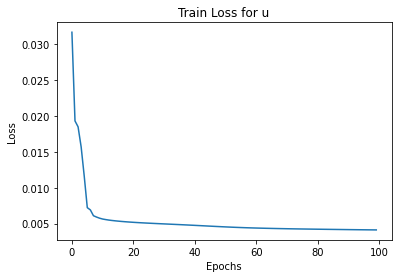

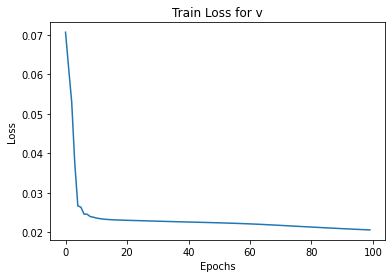

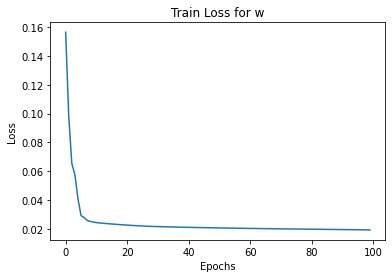

In [ ]:
net1 = Autoencoder()
optimizer = optim.Adam(net1.parameters(), lr = learning) #using the Adam optimizer

corr_train_each = torch.reshape(corr_train[:,0,:,:],(80,1,nx,nz))
orig_train_each = torch.reshape(orig_train[:,0,:,:],(80,1,nx,nz))

net1.to(device)
train_loss = train(net1, corr_train_each, orig_train_each, epochs)
plt.figure(1)
plt.plot(train_loss)
plt.title('Train Loss for u')
plt.xlabel('Epochs')
plt.ylabel('Loss')

net2 = Autoencoder()
optimizer = optim.Adam(net2.parameters(), lr = learning) #using the Adam optimizer

corr_train_each = torch.reshape(corr_train[:,1,:,:],(80,1,nx,nz))
orig_train_each = torch.reshape(orig_train[:,1,:,:],(80,1,nx,nz))

net2.to(device)
train_loss = train(net2, corr_train_each, orig_train_each, epochs)
plt.figure(2)
plt.plot(train_loss)
plt.title('Train Loss for v')
plt.xlabel('Epochs')
plt.ylabel('Loss')

net3 = Autoencoder()
optimizer = optim.Adam(net3.parameters(), lr = learning) #using the Adam optimizer

corr_train_each = torch.reshape(corr_train[:,2,:,:],(80,1,nx,nz))
orig_train_each = torch.reshape(orig_train[:,2,:,:],(80,1,nx,nz))

net3.to(device)
train_loss = train(net3, corr_train_each, orig_train_each, epochs)
plt.figure(3)
plt.plot(train_loss)
plt.title('Train Loss for w')
plt.xlabel('Epochs')
plt.ylabel('Loss')



Reconstruct the images using the trained network

In [ ]:
u_recon = test_image_reconstruction(net1,torch.reshape(corr_full[:,0,:,:],(ny,1,nx,nz)))
v_recon = test_image_reconstruction(net2,torch.reshape(corr_full[:,1,:,:],(ny,1,nx,nz)))
w_recon = test_image_reconstruction(net3,torch.reshape(corr_full[:,2,:,:],(ny,1,nx,nz)))
u_recon = u_recon.cpu().detach().numpy()
v_recon = v_recon.cpu().detach().numpy()
w_recon = w_recon.cpu().detach().numpy()

urecon = np.zeros((ny,channel,nx,nz))

for i in range(ny):
  urecon[i,:,:,:] = np.reshape(np.stack((u_recon[i,:,:],v_recon[i,:,:],w_recon[i,:,:])),(1,3,101,101))


revert back to original range and standard deviation of original data

In [ ]:
uflucrecon = np.zeros(np.shape(urecon))
uflucsparse2 = np.zeros(np.shape(urecon))

for i in range(ny):
  for j in range(channel):
    uflucrecon[i,j,:,:] = urecon[i,j,:,:]*ustd[i,j]*umax[j]
    uflucsparse2[i,j,:,:] = uflucsparse[i,j,:,:]*ustd[i,j]*umax[j]


# Plot Results

Check the 2D streamwise velocity contour of the data

In [ ]:
X,Y = np.meshgrid(xdata,zdata)

yind = 10
uind = 0

Text(0, 0.5, 'z+')

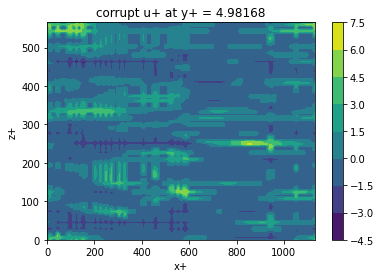

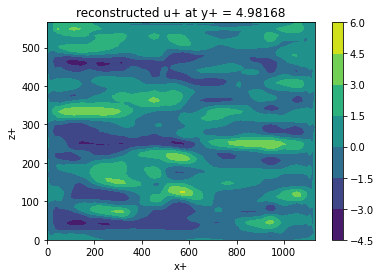

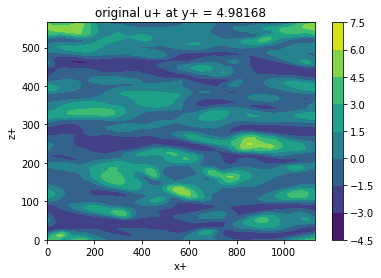

In [ ]:
plt.figure(1)
plt.contourf(X,Y,np.transpose(uflucsparse2[yind,uind,:,:]))
plt.colorbar()
plt.title('corrupt u''+ at y+ = ' + str(ydata[yind]))
plt.xlabel('x+')
plt.ylabel('z+')

plt.figure(2)
plt.contourf(X,Y,np.transpose(uflucrecon[yind,uind,:,:]))
plt.colorbar()
plt.title('reconstructed u''+ at y+ = ' + str(ydata[yind]))
plt.xlabel('x+')
plt.ylabel('z+')

plt.figure(3)
plt.contourf(X,Y,np.transpose(udata[yind,uind,:,:]))
plt.colorbar()
plt.title('original u''+ at y+ = ' + str(ydata[yind]))
plt.xlabel('x+')
plt.ylabel('z+')

save the data to be used in matlab 

In [ ]:
from scipy.io import savemat
savemat(PATH + 'ucorrupt.mat',{'data': uflucsparse2})
savemat(PATH + 'ureconstruct.mat',{'data': uflucrecon})
savemat(PATH + 'uoriginal.mat',{'data': udata})